
## Exercise 1 

**(a)** Given a polynomial of p-th degree, we have p features **and** an intercept: **p+1** parameters. Without intercept: **p**.

**(b)** Too many degrees of freedom in relation to the number of datapoints given could result in **overfitting**.

**(c)** Too few degrees of freedom could result in **underfitting**. The model can overlook certain patterns due to its limited parameter space.

**(d)** The effective degrees of freedom of the ridge regression fit is
$$ df(\lambda) = \operatorname{tr}\!\Big[X (X^{T}X + \lambda I)^{-1} X^{T}\Big] = \sum_{j=1}^p \frac{d_j^2}{d_j^2 + \lambda}$$

**(e)** Prefer **Ridge** when multicollinearity is present. The Ridge regression in fact makes us able to easilly invert the X matrix even if it is singular.

**(f)** Prefer **OLS** when we have uncorrelated columns and we want simpler estimates, whithout having some of our parameters shrunk toward zero due to the additional $ \lambda$ factor.



## Exercise 2 
Minimize the quantity:
$$L(\beta) = \frac{1}{n}\|y - X\beta\|^{2} + \lambda \|\beta\|^{2} $$
So we set $$\frac{\partial L}{\partial \beta} = 0$$ 
Using the same relations that were used on the previous week exercises we can define determine the expression that satisfy the following relation: $$X^{\top}X\beta + \lambda\beta = (X^{\top}X + \lambda I)\beta = X^{\top}y $$ and therefore the ridge regression estimator is:
$$ \hat{\beta} = (X^{\top}X + \lambda I)^{-1} X^{\top}y $$


## Exercise 3


Initializing data (same as previous excercises)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

SEED = 42
np.random.seed(SEED)
n = 100
x = np.linspace(-3, 3, n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2) + np.random.normal(0, 0.1)

def polynomial_features(x: np.ndarray, degree: int, intercept: bool = False) -> np.ndarray:
    x = np.asarray(x).reshape(-1)
    X = np.column_stack([x**k for k in range(1, degree+1)])
    if intercept:
        X = np.column_stack([np.ones_like(x), X])
    return X

# no intercept column (offset handled separately)
X = polynomial_features(x, degree=3, intercept=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# For plotting
x_train = X_train[:, 0]
x_test = X_test[:, 0]

Implemating scaling using sklearn standard scaler and plotting.

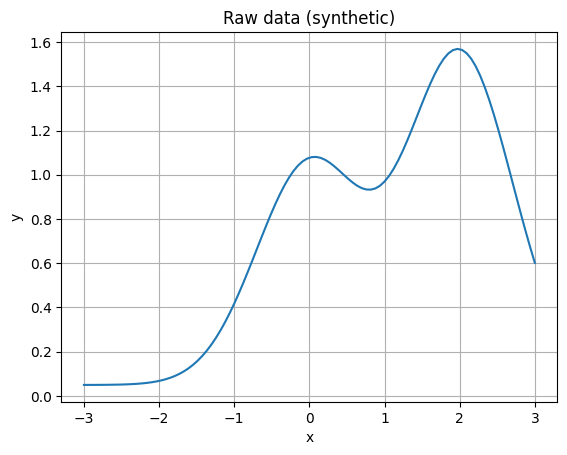

In [44]:
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
y_offset = np.mean(y_train)

plt.figure()
plt.plot(x, y)
plt.title("Raw data (synthetic)")
plt.xlabel("x"); plt.ylabel("y")
plt.grid()
plt.show()


## Exercise 4
Closed form: $\hat{\beta} = (X^{\top}X + \lambda I)^{-1} X^{\top}y $, with X scaled and **no** intercept column. The intercept is handled via a constant offset y_offset = mean(y_train).


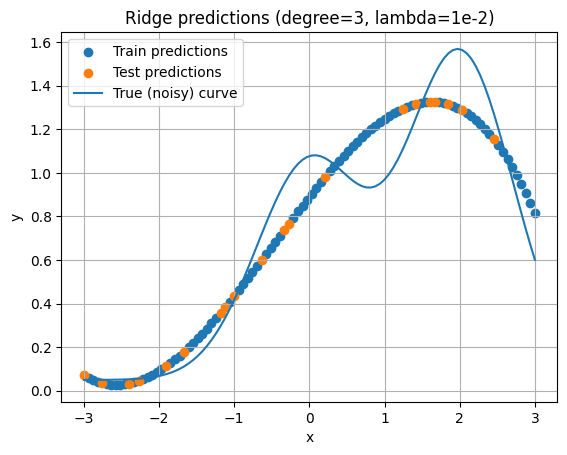

In [45]:
from numpy.linalg import inv

def ridge_parameters_closed_form(X: np.ndarray, y: np.ndarray, lam: float) -> np.ndarray:
    XT_X = X.T @ X
    p = XT_X.shape[0]
    return inv(XT_X + lam * np.eye(p)) @ (X.T @ y)

def predict_ridge(Xs: np.ndarray, beta: np.ndarray, y_offset: float) -> np.ndarray:
    return Xs @ beta + y_offset

lam = 1e-2
beta = ridge_parameters_closed_form(X_train_s, y_train, lam)
yhat_train = predict_ridge(X_train_s, beta, y_offset)
yhat_test  = predict_ridge(X_test_s,  beta, y_offset)

plt.figure()
plt.scatter(x_train, yhat_train, label="Train predictions")
plt.scatter(x_test,  yhat_test,  label="Test predictions")
plt.plot(x, y, label="True (noisy) curve")
plt.title("Ridge predictions (degree=3, lambda=1e-2)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend()
plt.grid()
plt.show()


## Exercise 4 
Creating model evaluation functions

In [46]:

from sklearn.metrics import mean_squared_error

def fit_and_score_degree(x: np.ndarray, y: np.ndarray, degree: int, lam: float, random_state: int = 123):
    X = polynomial_features(x, degree=degree, intercept=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)
    y_offset = float(np.mean(y_train))

    beta = ridge_parameters_closed_form(X_train_s, y_train, lam)
    yhat_train = predict_ridge(X_train_s, beta, y_offset)
    yhat_test  = predict_ridge(X_test_s,  beta, y_offset)
    return mean_squared_error(y_train, yhat_train), mean_squared_error(y_test, yhat_test)


**(a)** Evaluating different degrees from 1 to 5

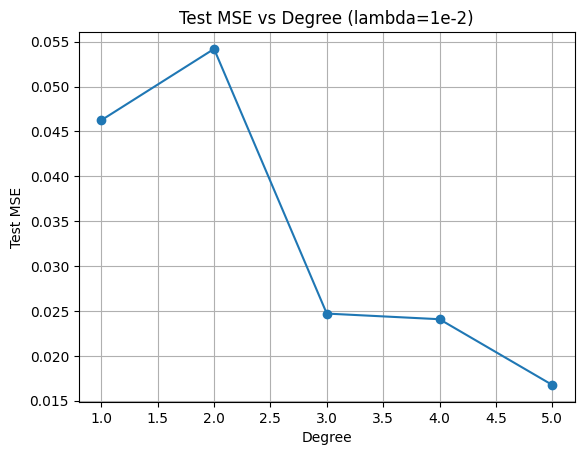

In [47]:
degrees = np.arange(1, 6)
lam_fixed = 1e-2
train_mse_a, test_mse_a = [], []
for d in degrees:
    tr, te = fit_and_score_degree(x, y, d, lam_fixed)
    train_mse_a.append(tr); test_mse_a.append(te)

plt.figure()
plt.plot(degrees, test_mse_a, marker='o')
plt.title("Test MSE vs Degree (lambda=1e-2)")
plt.xlabel("Degree"); plt.ylabel("Test MSE")
plt.grid()
plt.show()

**(b)** Setting the degree to 3, and  evaluating the relative mean squared errors with lambdas on a logarithmic scale

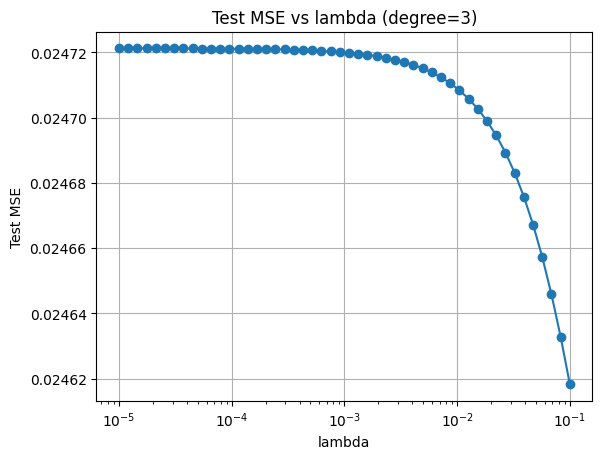

In [48]:
lambdas = np.logspace(-5, -1, 50)
train_mse_b, test_mse_b = [], []
for lam in lambdas:
    tr, te = fit_and_score_degree(x, y, degree=3, lam=lam)
    train_mse_b.append(tr); test_mse_b.append(te)

plt.figure()
plt.semilogx(lambdas, test_mse_b, marker='o')
plt.title("Test MSE vs lambda (degree=3)")
plt.xlabel("lambda"); plt.ylabel("Test MSE")
plt.grid()
plt.show()

**(c)** Heatmap degrees x lambdas

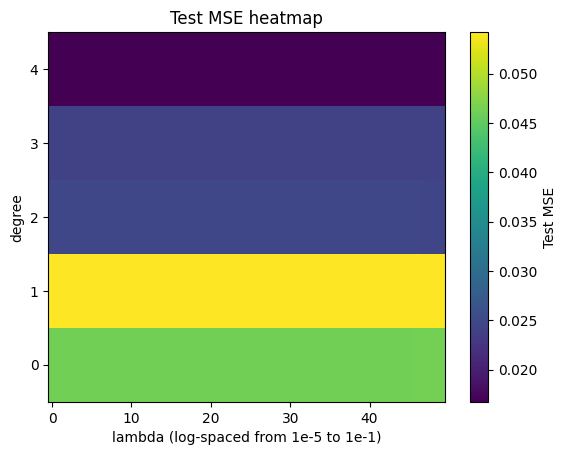

In [49]:
heat = np.zeros((len(degrees), len(lambdas)))
for i, d in enumerate(degrees):
    for j, lam in enumerate(lambdas):
        tr, te = fit_and_score_degree(x, y, degree=d, lam=lam)
        heat[i, j] = te

plt.figure()
im = plt.imshow(heat, aspect='auto', origin='lower')
plt.title("Test MSE heatmap")
plt.xlabel("lambda (log-spaced from 1e-5 to 1e-1)")
plt.ylabel("degree")
plt.colorbar(im, label="Test MSE")
plt.show()